# Survival Analysis #

#### Boiler plate libraries ####

In [1]:
import pandas as pd
from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor
import seaborn as sns
from lifelines import CoxPHFitter
from lifelines.statistics import logrank_test
import numpy as np

#### Load in and understand data ####

In [2]:
dir = "/Users/emudr/Desktop/data/BostonVA_data/"

df_events = pd.read_csv(dir + 'mock_events.csv', parse_dates = ['event_date', 'censor_date'])
df_patients = pd.read_csv(dir + 'mock_patients.csv', parse_dates = ['start_date'])

print(df_events.info())
print(df_events.describe())

print(df_patients.info())
print(df_patients.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   patient_id   100 non-null    int64         
 1   event_date   44 non-null     datetime64[ns]
 2   event        99 non-null     float64       
 3   censor_date  55 non-null     datetime64[ns]
dtypes: datetime64[ns](2), float64(1), int64(1)
memory usage: 3.3 KB
None
        patient_id                     event_date      event  \
count   100.000000                             44  99.000000   
mean   1050.500000  2019-10-22 05:27:16.363636480   0.454545   
min    1001.000000            2015-09-11 00:00:00   0.000000   
25%    1025.750000            2018-10-18 18:00:00   0.000000   
50%    1050.500000            2020-02-26 12:00:00   0.000000   
75%    1075.250000            2020-11-30 00:00:00   1.000000   
max    1100.000000            2023-02-09 00:00:00   1.000000   
std      29.01149

#### Merge data ####

In [3]:
df = pd.merge(df_events, df_patients, how = "outer" , on = "patient_id")

#### EDA / Data Viz ####

0
patient_id      0
event_date     56
event           1
censor_date    45
age             1
sex             4
treatment       0
start_date      0
dtype: int64
Empty DataFrame
Columns: [patient_id, event_date, event, censor_date, age, sex, treatment, start_date]
Index: []
Empty DataFrame
Columns: [patient_id, event_date, event, censor_date, age, sex, treatment, start_date]
Index: []


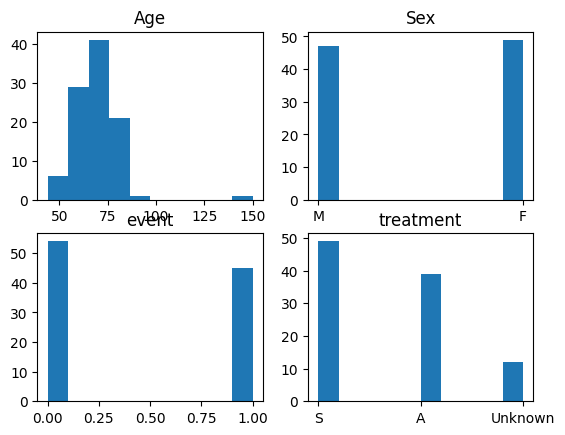

In [4]:
## Check for missing data, duplicates, wrong data, outliers etc ###

print(df.duplicated().sum())
print(df.isna().sum())

fix, axs = plt.subplots(2,2)
axs[0,0].hist(df['age'].dropna())
axs[0,0].set_title('Age')

axs[0,1].hist(df['sex'].dropna())
axs[0,1].set_title('Sex')

axs[1,0].hist(df['event'].dropna())
axs[1,0].set_title('event')

axs[1,1].hist(df['treatment'].dropna())
axs[1,1].set_title('treatment')

## Check dates
print(df[df['censor_date'] < df['start_date']])
print(df[df['event_date'] < df['start_date']])

#### Data Cleaning ####

In [5]:
#### Data Cleaning 

# Treatment unknown 
df = df[df['treatment']!='Unknown']

# age 150
df_male_1 = df[(df['sex']=='M') & (df['event'] ==1)]['age'].median()
df.loc[df['age'] == 150, 'age'] = df_male_1

# # OR 
# df['age'] = df['age'].replace(150, np.nan)
# df['age'] = df['age'].fillna(df['age'].median())
# df['sex'] = df['sex'].fillna(df['sex'].mode()[0])
# NA values 
df = df.dropna(subset=['sex'])


#### Dates ####
def get_duration(df):
    if df['event'].iloc[0] == 1 : 
        df['duration'] = (df['event_date'] - df['start_date']).dt.days
    else : 
        df['duration'] = (df['censor_date'] -df['start_date']).dt.days
    return df 
        
df = df.groupby('event', as_index = False).apply(get_duration)
df['duration'].replace(np.nan, df['duration'].median(), inplace = True)
print(df.info())


<class 'pandas.core.frame.DataFrame'>
MultiIndex: 84 entries, (np.int64(0), np.int64(0)) to (np.int64(1), np.int64(99))
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   patient_id   84 non-null     int64         
 1   event_date   37 non-null     datetime64[ns]
 2   event        84 non-null     float64       
 3   censor_date  46 non-null     datetime64[ns]
 4   age          84 non-null     float64       
 5   sex          84 non-null     object        
 6   treatment    84 non-null     object        
 7   start_date   84 non-null     datetime64[ns]
 8   duration     84 non-null     float64       
dtypes: datetime64[ns](3), float64(3), int64(1), object(2)
memory usage: 8.9+ KB
None


C:\Users\emudr\AppData\Local\Temp\ipykernel_51004\810500024.py:26: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('event', as_index = False).apply(get_duration)
C:\Users\emudr\AppData\Local\Temp\ipykernel_51004\810500024.py:27: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perfor

#### Kaplan Meier Model ####

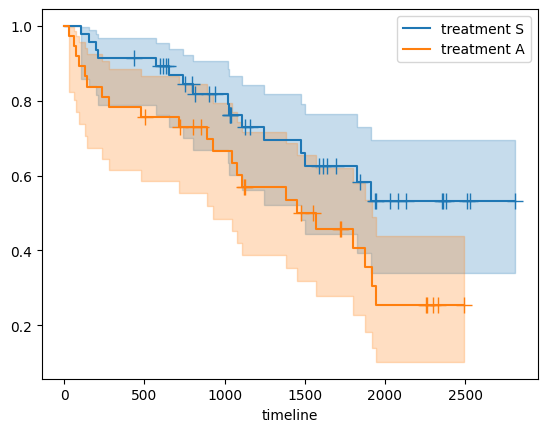

In [6]:
kmf = KaplanMeierFitter()
# Treatment differences

for treatment in df['treatment'].unique() :
    df_treatment = df[df['treatment'] == treatment]
    kmf.fit(df_treatment[['duration']], df_treatment[['event']], label = f"treatment {treatment}")
    kmf.plot_survival_function(show_censors=True)


**Interpretation:** \
At 500 days:  Treatment S subjects have ~90% chance of surviving 500 days, while Treatment A subjects haev ~78% chance of surviving 500 days. \
At 2000 days: Treatment S subjects have ~55% chance of surviving 2000 days, while Treatment A subjects have ~24% chance of surivivng 2000 days. 

#### Log Rank Tests ####

In [7]:
# Split into 2 dfs treatmentA and treatmentS
treatmentA = df[df['treatment']=='A']
treatmentS= df[df['treatment'] =='S']

model = logrank_test(treatmentA['duration'], treatmentS['duration'], treatmentA['event'], treatmentS['event'])
model.print_summary()

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           4.15 0.04      4.59

**Interpretation**\
p-value <0.05 indicates statistically significant difference in surivval distributions between treatment A and treatment S. 

#### Cox Hazard Probability Test ####

<lifelines.CoxPHFitter: fitted with 84 total observations, 46 right-censored observations>
             duration col = 'duration'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 84
number of events observed = 38
   partial log-likelihood = -144.82
         time fit was run = 2025-07-25 15:29:20 UTC

---
             coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                    
age         -0.01      0.99      0.02           -0.04            0.03                0.96                1.03
sex_M       -0.22      0.80      0.34           -0.90            0.45                0.41                1.57
treatment_S -0.59      0.55      0.34           -1.26            0.07                0.28                1.08

             cmp to     z    p  -log2(p)
covariate                               
age            0.00 -0.36 0.72      0.48
sex_M          0.00 -0.64 0.52      0.95
treatment_S    0.00 -1.74 0.08      3.62
---
Concordance = 0.59
Partial AIC = 295.65
log-likelihood ratio test = 4.60 on 3 df
-log2(p) of ll-ratio test = 2.29

<Axes: xlabel='HR (95% CI)'>

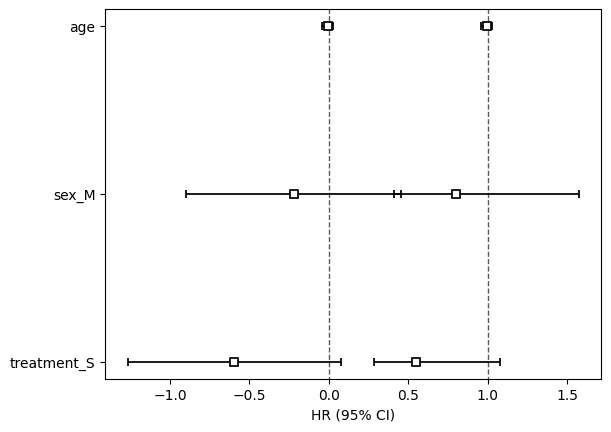

In [8]:
cph = CoxPHFitter()
df = pd.get_dummies(df, columns = ['sex', 'treatment'], drop_first = False)

'''
# If you have more than one dummy variable per col 
col_list = df.columns[df.columns.str.contains(f"^sex|^treatment")].to_list()
col_list = ['duration', 'event', 'age'] + col_list
df = df[col_list]
OR 
df['sex'] = df['sex'].map({'M': 1, 'F': 0})
'''

df = df[['event', 'age', 'sex_M', 'treatment_S', 'duration']]
cph.fit(df, duration_col = 'duration', event_col = 'event')
cph.print_summary()
cph.plot() # Plots the log-hazard ratios
#cph.plot(hazard_ratios=True) # Plots the hazard ratios instead
cph.check_assumptions(df, p_value_threshold=0.05, show_plots = True)

**Interpreation:**\
exp(coef) is hazard ratio 
Hazard Ratio (HR) = 1 (no difference between groups), HR<1 lower chance of death, HR > higher chance of death \

age :  HR = 0.99, p= 0.72 --> No significant effect of age.  A one year increase in age is associated with 1% decrease in hazard.\
sex_M:  HR = 0.80, p = 0.52 --> No signifcant effect of sex.  Males have about 20% lower hazard than females, but not significant \
treatment_S: HR = 0.55, p = 0.08 --> Suggestive effect but not statisticall significant.  Subjects taking treatment S are 45% less likely to die (lower hazard) than those taking treatment A. \

Concrodance index of 1 is perfect ability to predict survival times, 0.5 indicates random predictive ability\
Concordance = 0.59 indicates modest predicitve ability

cph.plot() # Plots the log-hazard ratios --> Around 1 is good ?
cph.check_assumptions(df, p_value_threshold=0.05, show_plots = True)
📌 If the smoothed line deviates from horizontal, it suggests that the effect of the covariate changes over time, violating the PH assumption.

#### Check Assumptions ####


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...

Proportional hazard assumption looks okay.


[[<Axes: xlabel='rank-transformed time\n(p=0.6860)'>,
  <Axes: xlabel='km-transformed time\n(p=0.5872)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.4186)'>,
  <Axes: xlabel='km-transformed time\n(p=0.4385)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.6691)'>,
  <Axes: xlabel='km-transformed time\n(p=0.8229)'>]]

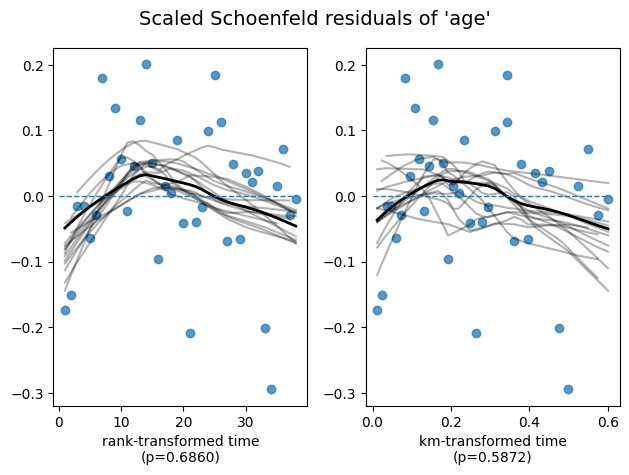

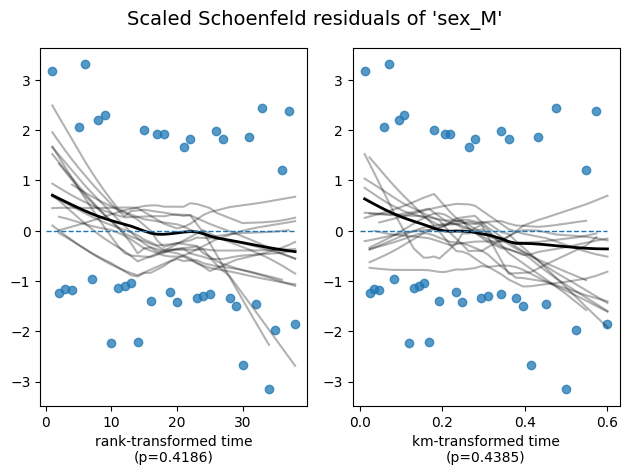

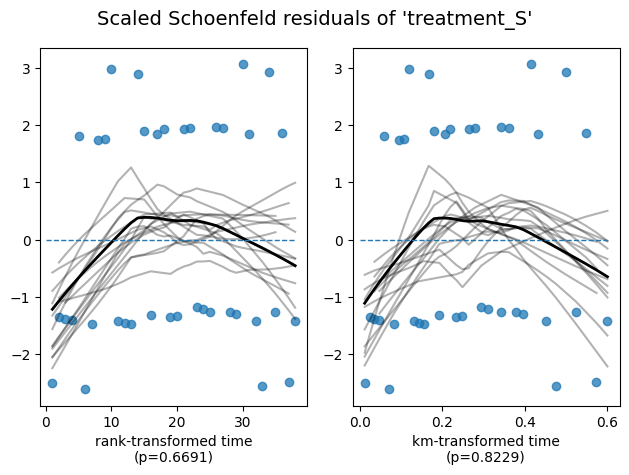

In [9]:
cph.check_assumptions(df, p_value_threshold=0.05, show_plots = True)

## IF Schoenfield Assumption for proportional hazards is not true 
- confirm the violation with plots
- add a time varying covariate 
- stratify the variable if a categorical variable violates PH ie sex 
- piecewise cox regression
- Use a different model 